In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import operator
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor,Pool, MetricVisualizer
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import TargetEncoder, MEstimateEncoder
from scipy import stats
import warnings
from joblib import parallel_backend
warnings.filterwarnings('ignore')

#Data loading and Preprocessing

In [ ]:
path="/content/drive/MyDrive/Colab Notebooks/competition/train.csv"
train_df = pd.read_csv(path)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We can see that many columns have so much messing values but the object type columns with null value are jaust labeled "NA" in the database what means that it is not a messing value but the "abscence" of such feature

For example : the value "NA" in the column "PoolQC" means the abscence of a pool in the house

so after analyzing the file "data_description.txt" we can find which columns that have this issue

In [ ]:
cols_fill_none = [
    'PoolQC', 'Alley', 'FireplaceQu', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'Fence', 'MiscFeature', 'MasVnrType'
]
#ken thama des donnée manquante fel resultat w thama correlation bin wa7da mel features w resultat najmou n3amrou eb regression lineaire les valeur manquant
#ken akther mel 4% mel les donnée ne9ssin manajamech nfasa5 les donnée

train_df[cols_fill_none] = train_df[cols_fill_none].fillna('None')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

after correcting the columns with "NA" value we still have some missing data so know we will try filling them with the best way possible

In [ ]:
# Identify columns with null values and their data types
null_counts = train_df.isnull().sum()
cols_with_nulls = null_counts[null_counts > 0]

# Display columns with nulls and their data types
for col in cols_with_nulls.index:
    print(f"Column: {col}, Null Count: {cols_with_nulls[col]}, Data Type: {train_df[col].dtype}")

Column: LotFrontage, Null Count: 259, Data Type: float64
Column: MasVnrArea, Null Count: 8, Data Type: float64
Column: Electrical, Null Count: 1, Data Type: object
Column: GarageYrBlt, Null Count: 81, Data Type: float64


In [ ]:
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(0)

### 🛠️ Handling Missing Values – Justification

After analyzing the columns with missing values, the following imputations were applied based on the data description and logical reasoning:

- **LotFrontage**: Missing values were filled using the **median LotFrontage of each Neighborhood**, assuming that houses in the same neighborhood tend to have similar lot frontage. This preserves local patterns and avoids introducing bias from a global statistic.

- **MasVnrArea**: Missing values were filled with **0**, indicating that the house likely has **no masonry veneer**, which aligns with the data description.

- **Electrical**: Only one value was missing, so it was filled with the **most frequent value** (`SBrkr`). This is a common and safe imputation method when there's only a single missing entry.

- **GarageYrBlt**: Missing values were filled with **0** to indicate **no garage**, as this field is expected to be missing only when a garage does not exist.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#Exploratory Data Analysis (EDA)

##Digital data distribution

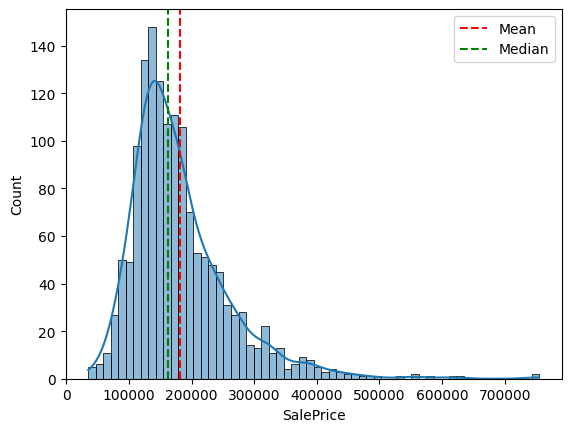

In [ ]:
sns.histplot(train_df['SalePrice'],bins=60,kde=True)
plt.axvline(train_df['SalePrice'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(train_df['SalePrice'].median(), color='green', linestyle='--', label='Median')
plt.legend()

In [ ]:
#dividing the data into numeric and categorical
df_num = train_df.select_dtypes(include=['int64', 'float64'])
categorical_cols = train_df.select_dtypes(include=['object']).columns

###Numerical column analysis

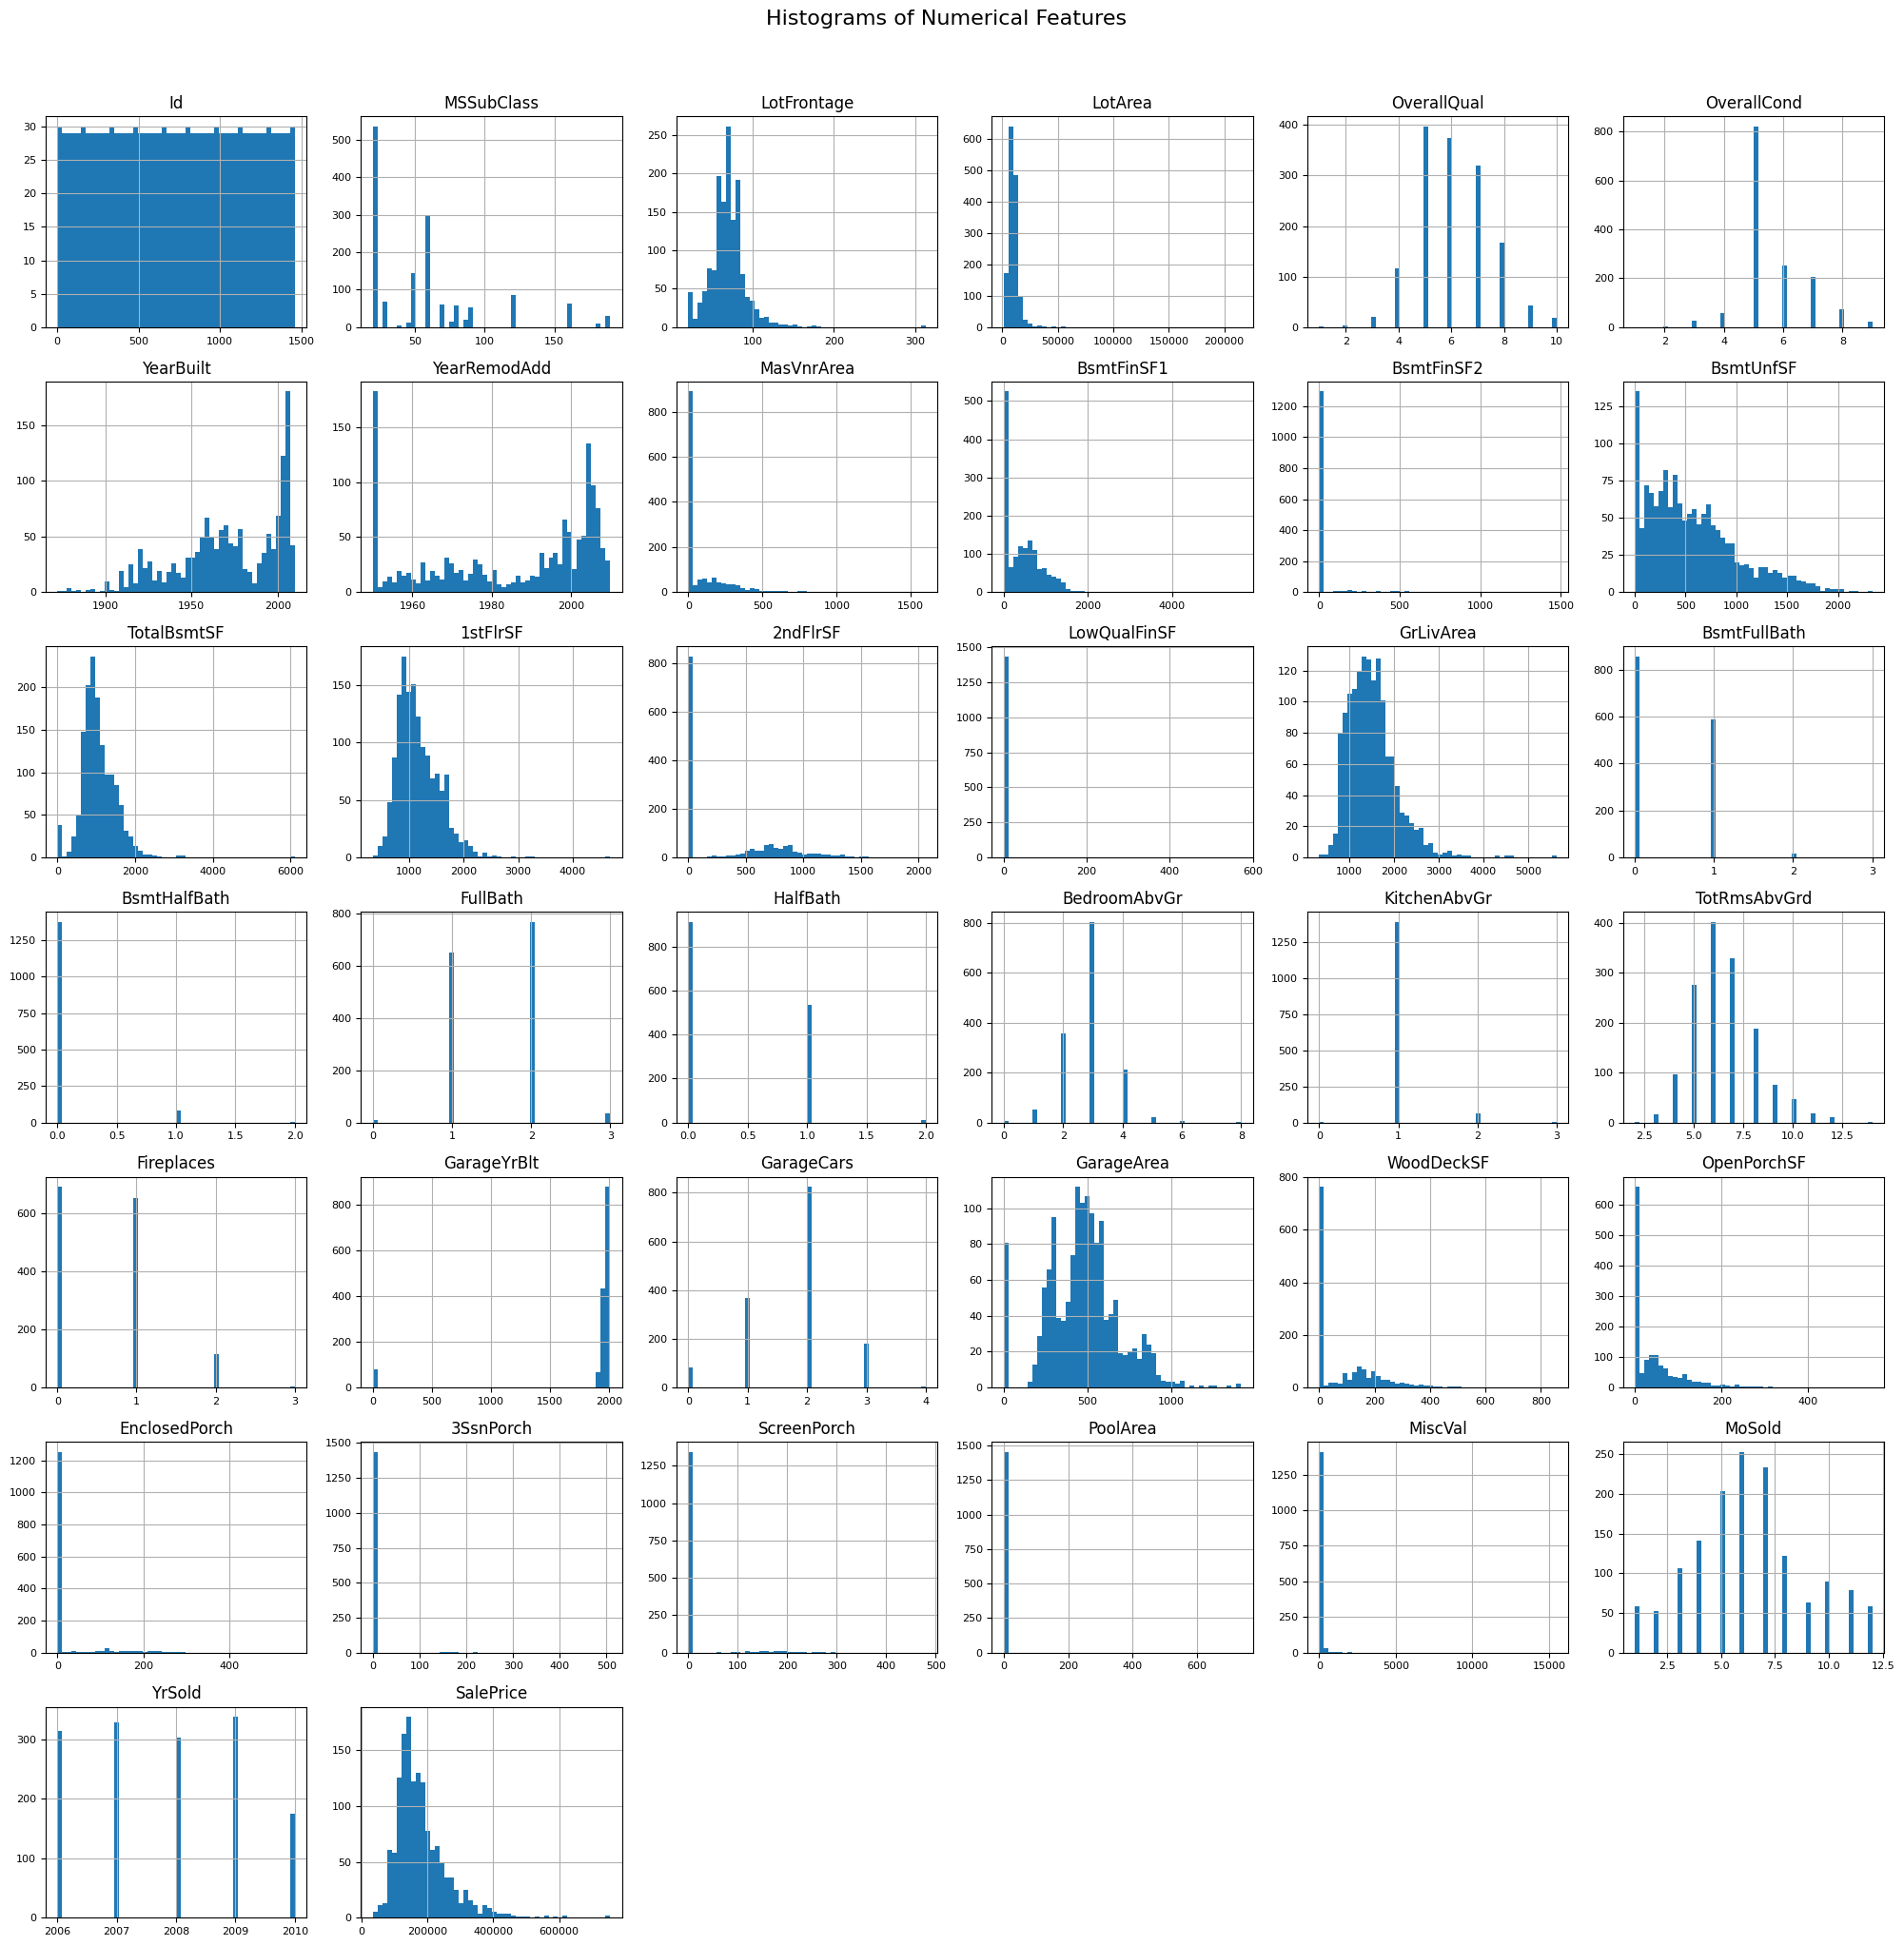

In [ ]:
df_num.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.suptitle('Histograms of Numerical Features', y=1.02, fontsize=16)
plt.tight_layout()

It seems like there are some features like TotalBsmtSF,LotFrontage that have a similare distribution of SalePrice

###Categorical column analysis

--- MSZoning ---
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

--- Street ---
Street
Pave    1454
Grvl       6
Name: count, dtype: int64

--- Alley ---
Alley
None    1369
Grvl      50
Pave      41
Name: count, dtype: int64

--- LotShape ---
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

--- LandContour ---
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

--- Utilities ---
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

--- LotConfig ---
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64

--- LandSlope ---
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64

--- Neighborhood ---
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide

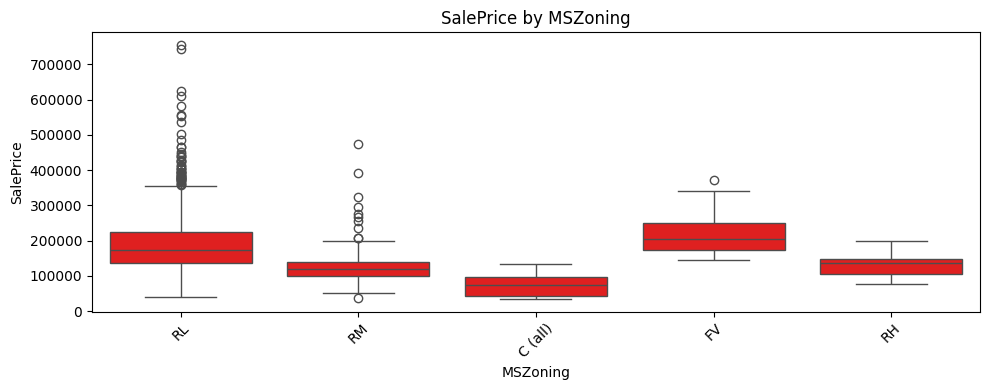

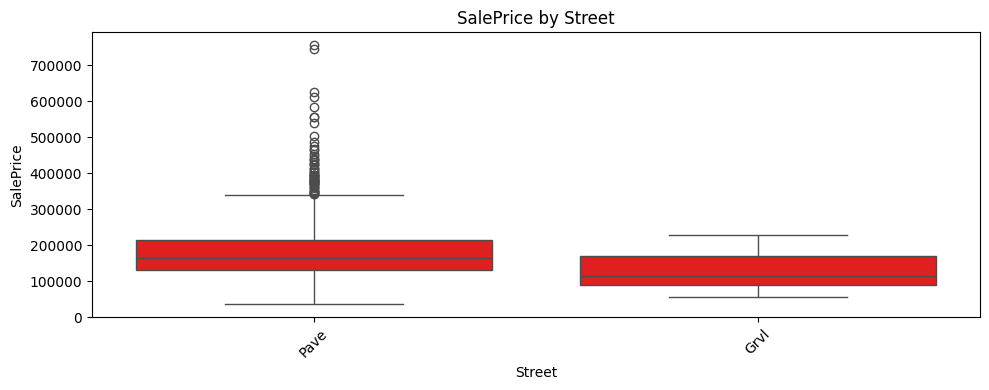

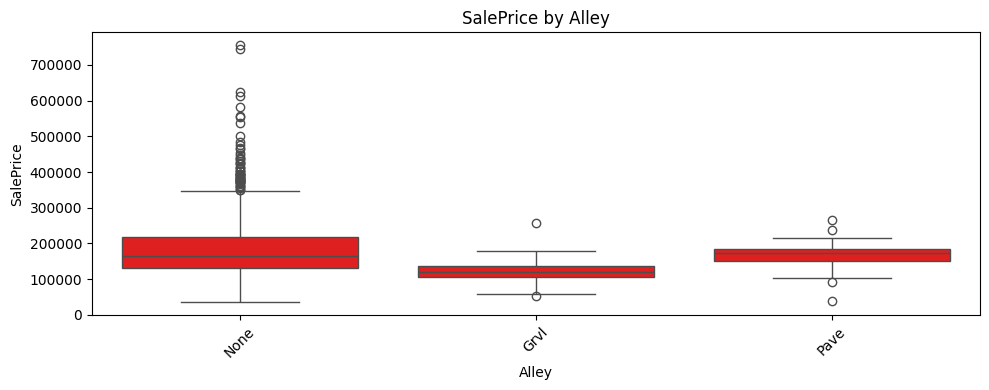

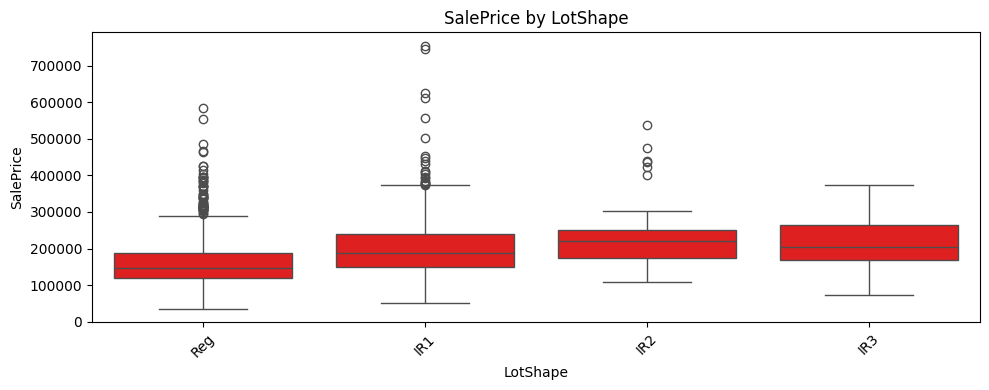

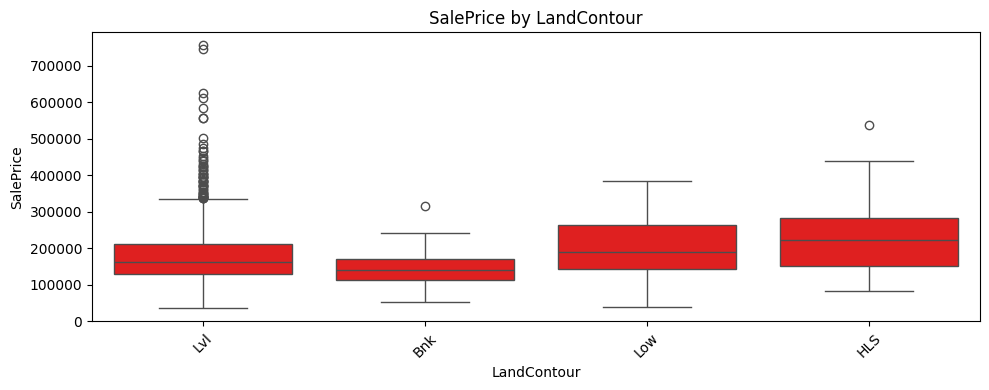

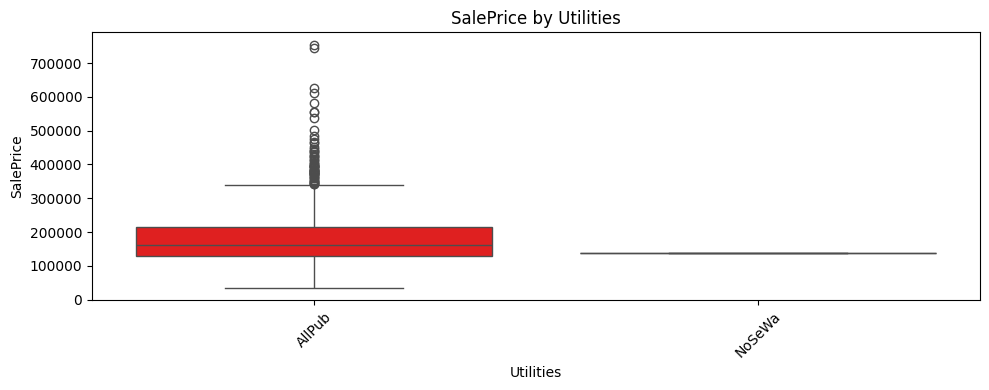

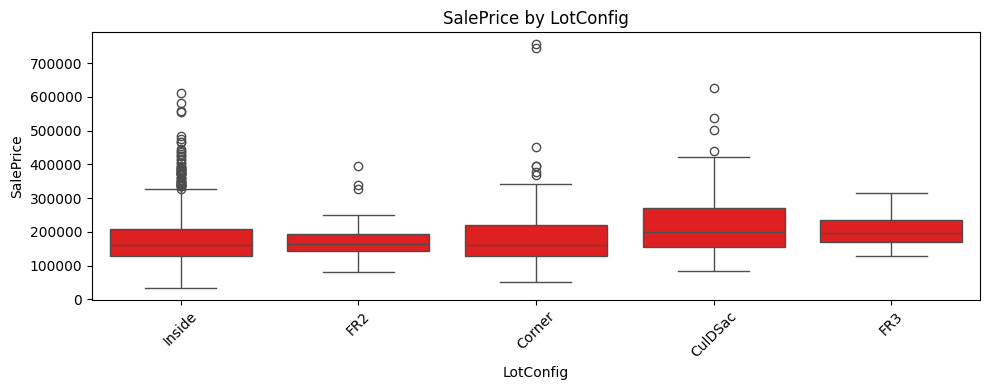

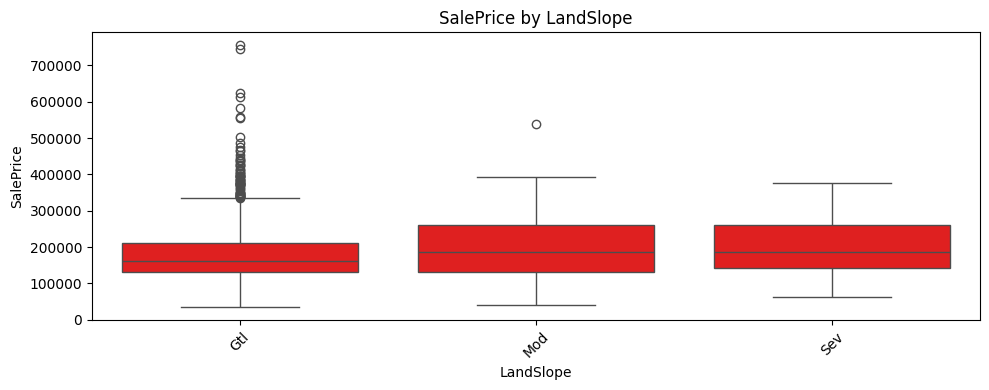

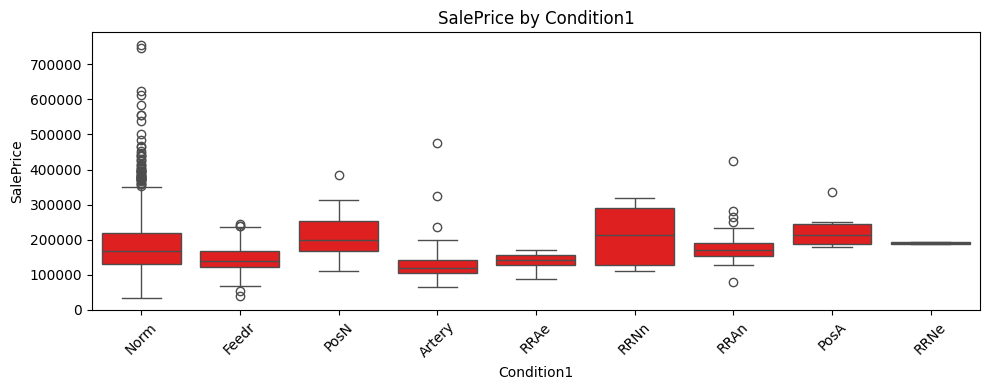

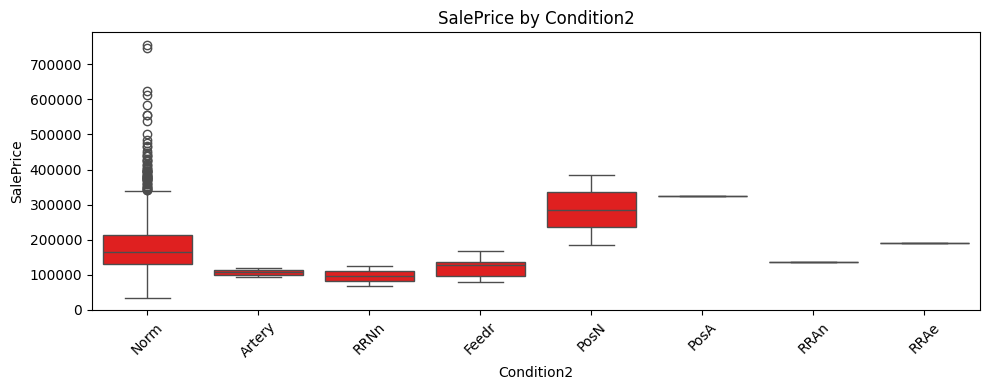

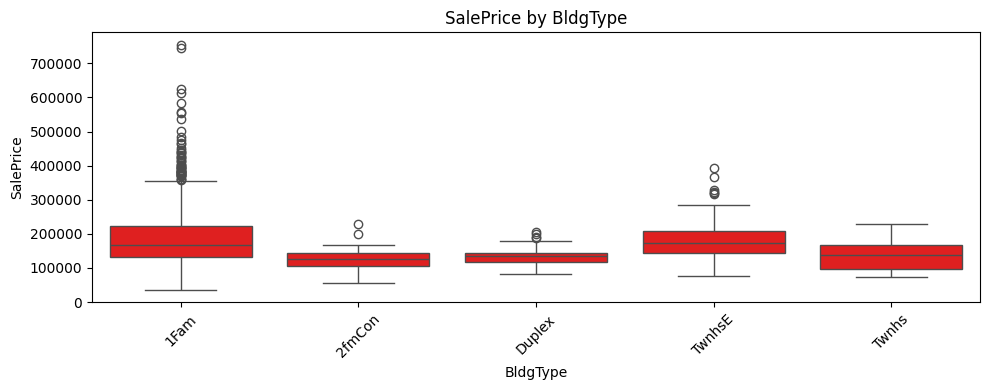

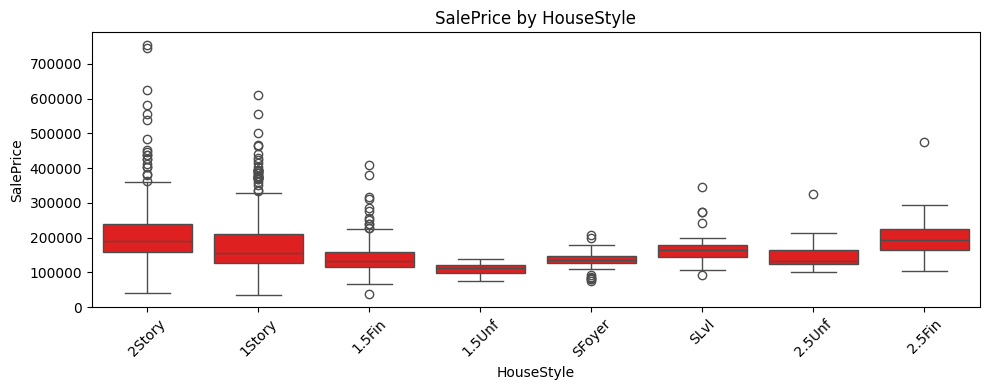

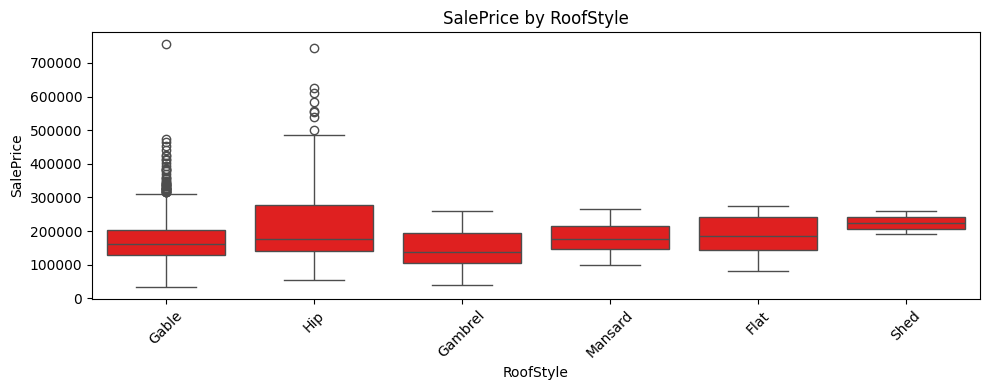

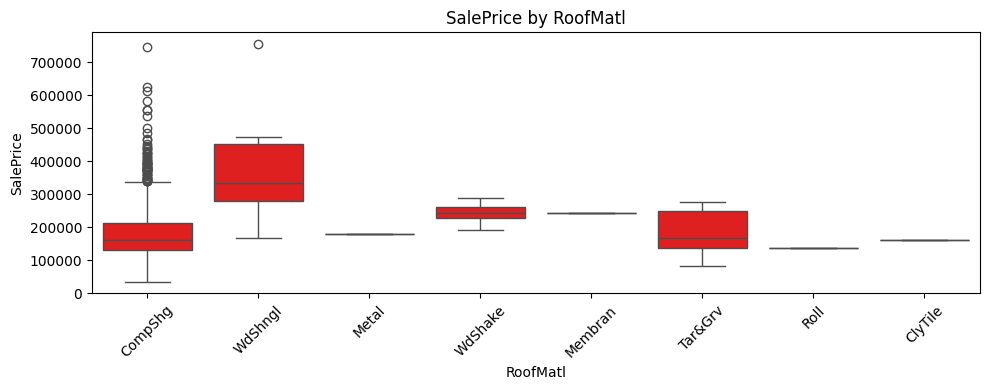

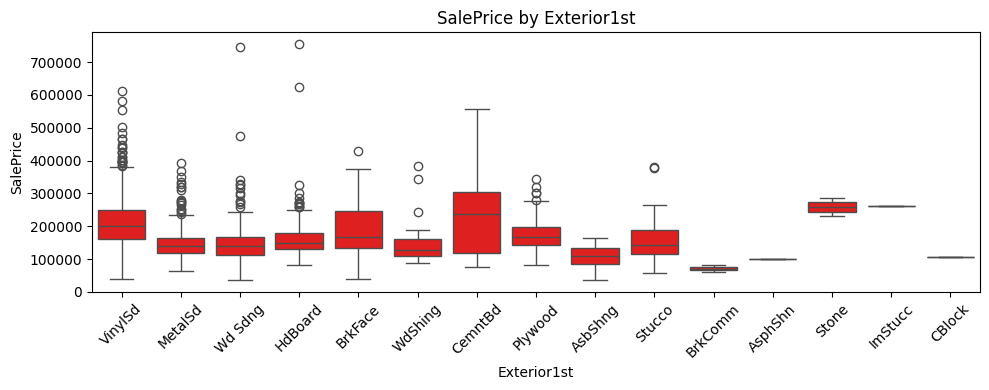

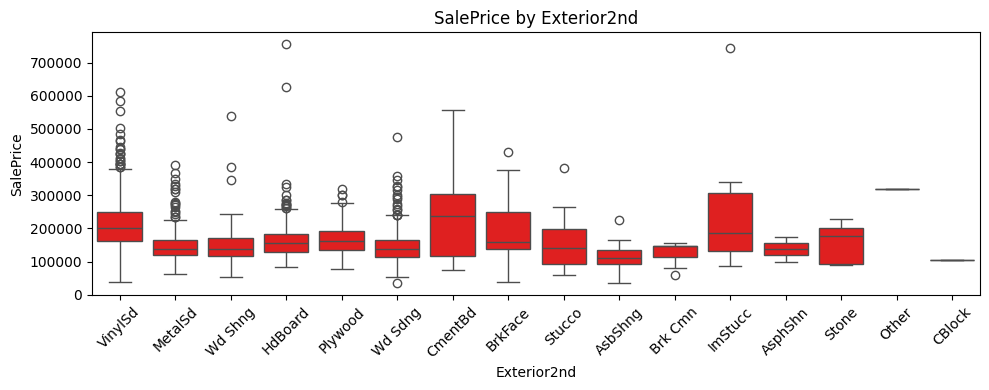

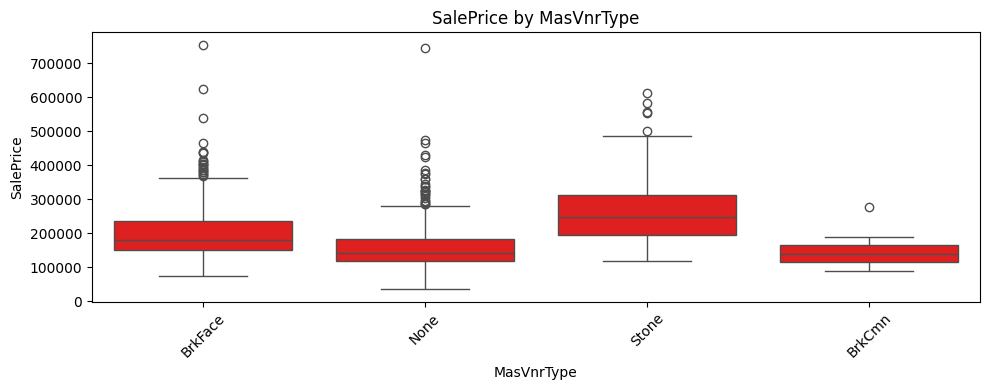

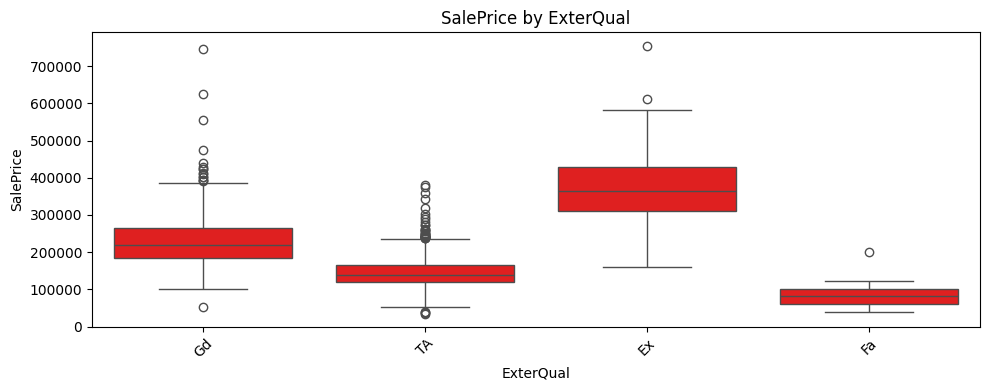

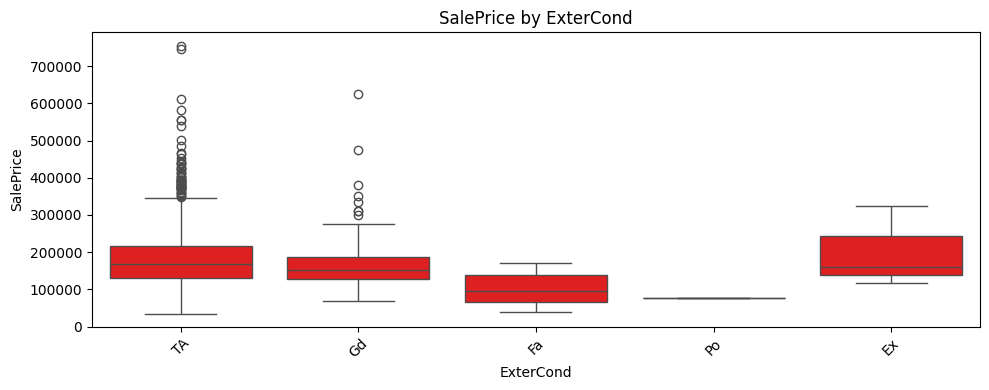

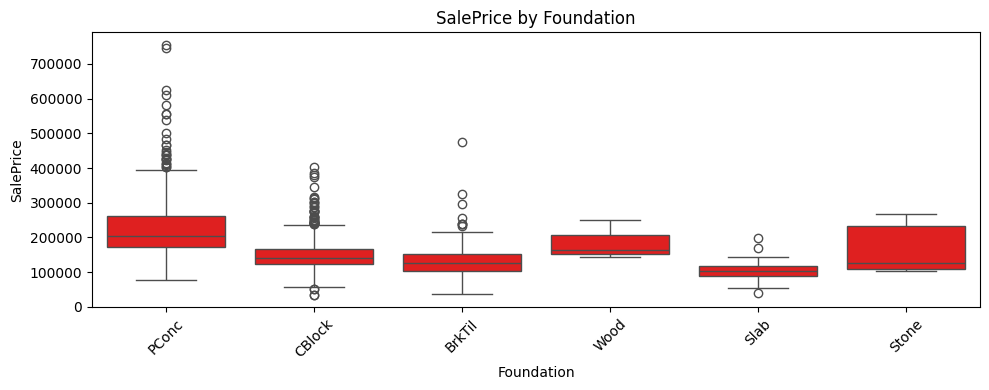

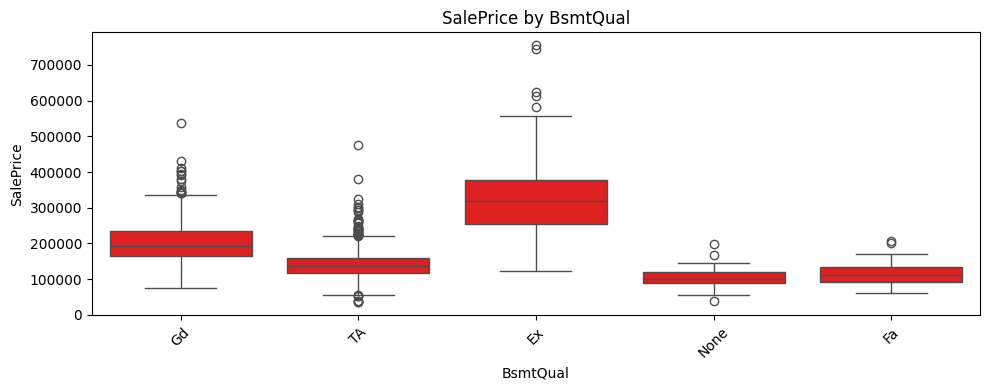

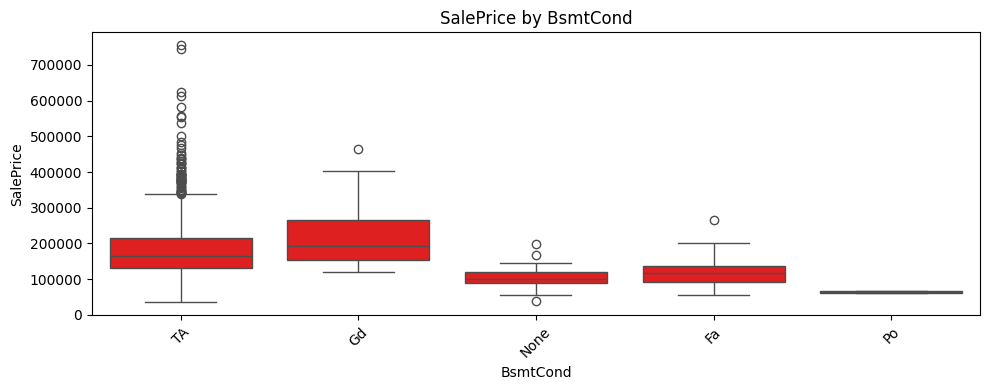

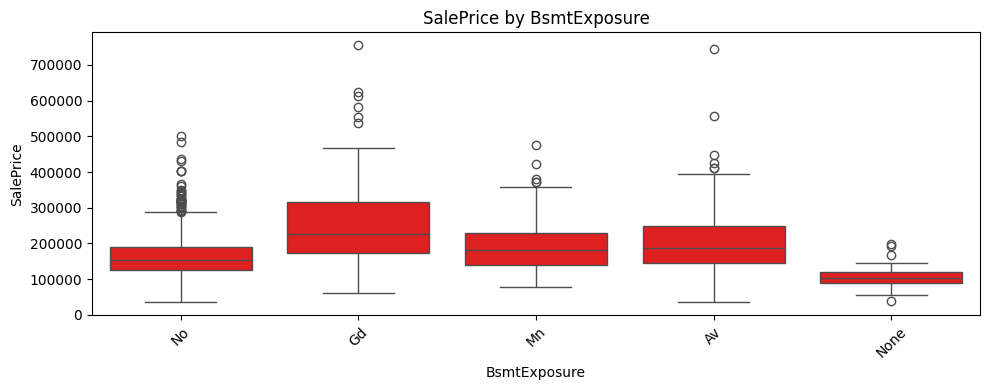

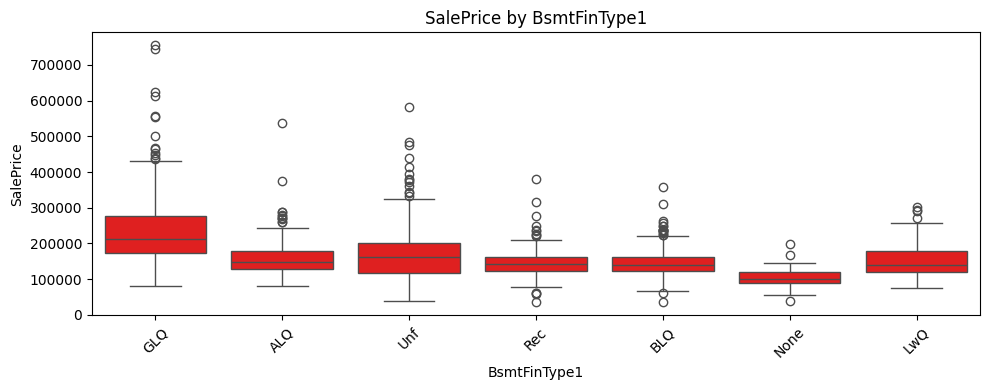

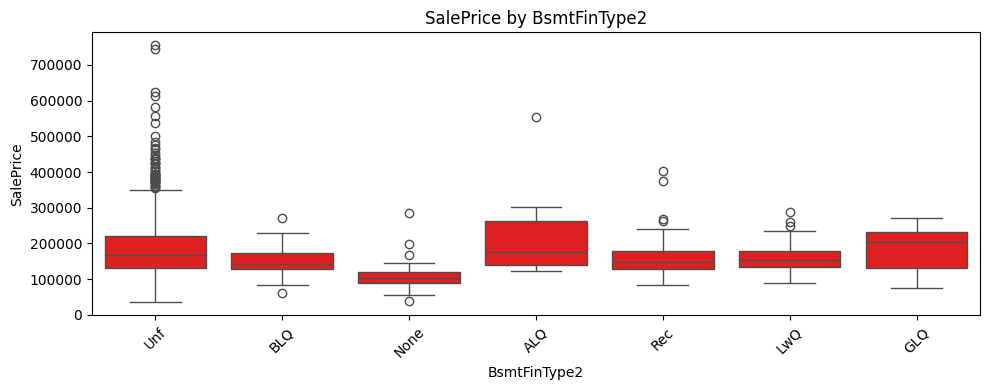

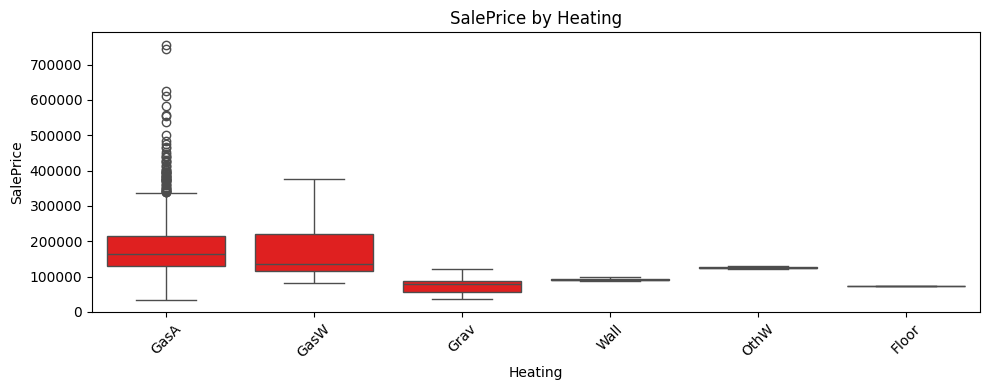

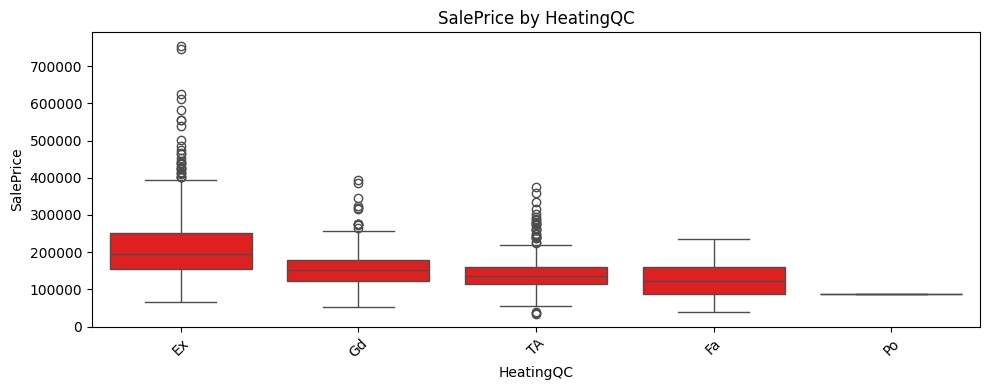

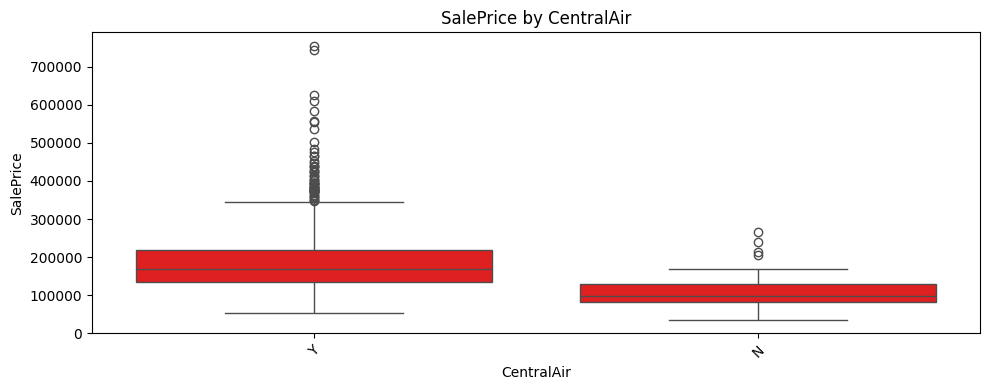

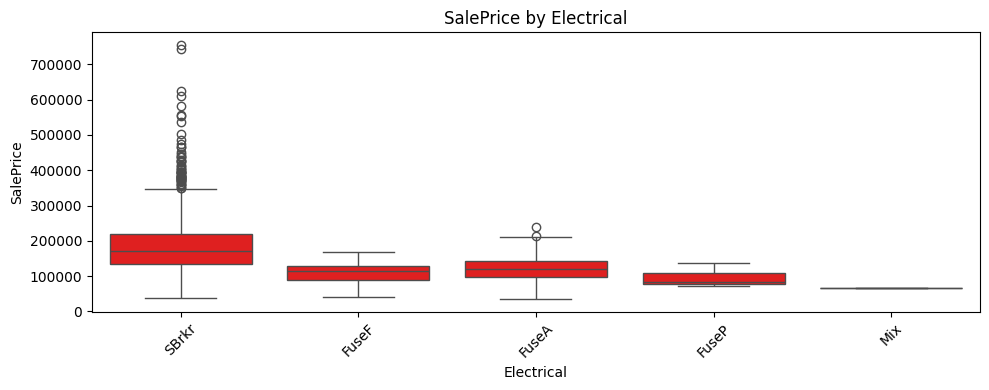

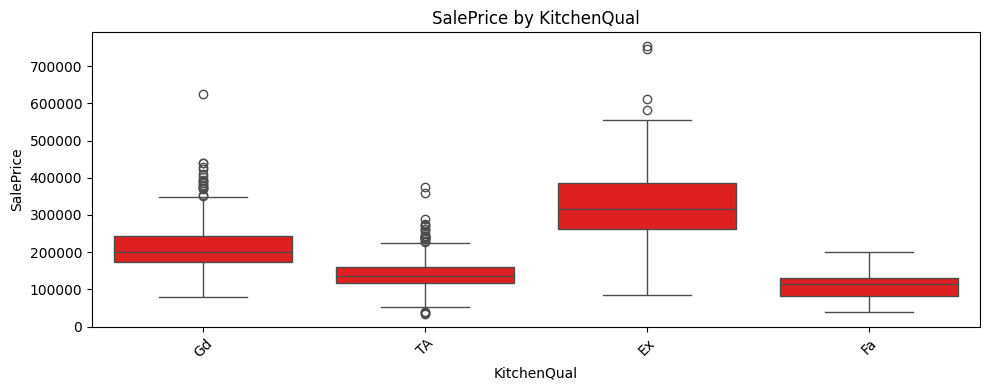

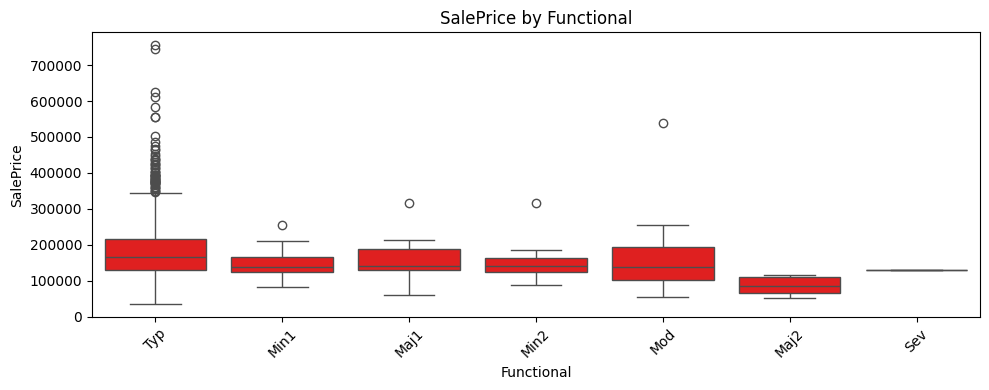

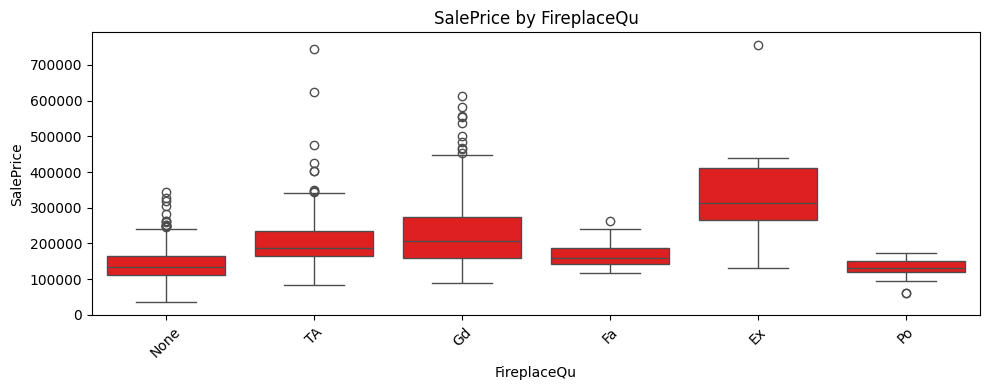

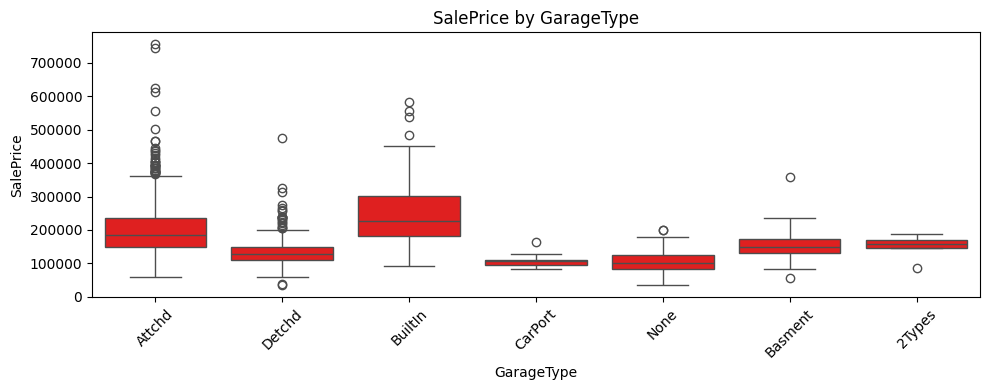

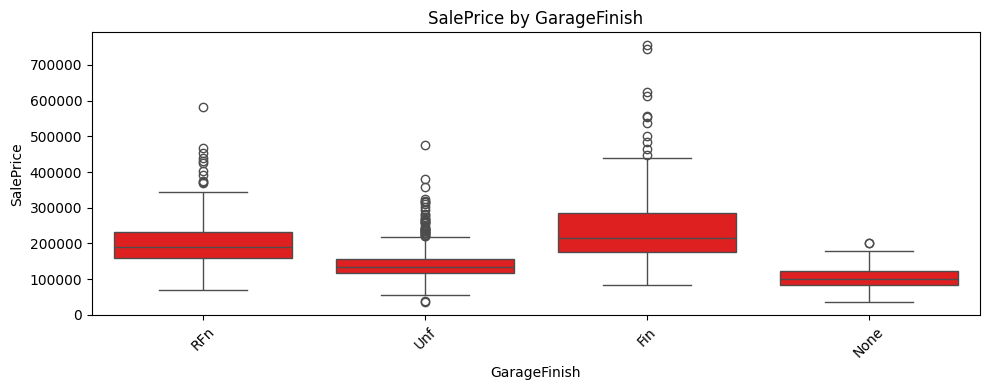

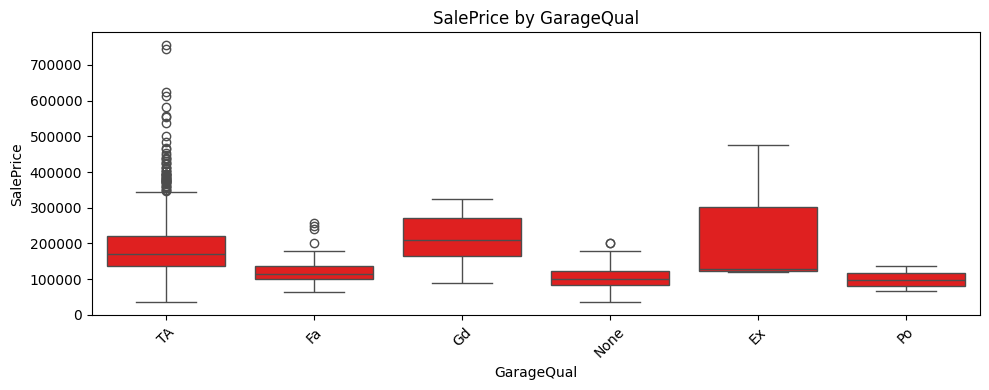

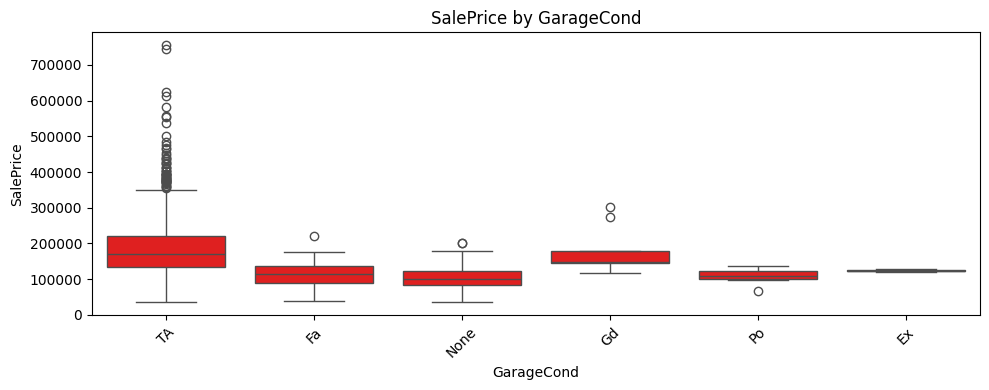

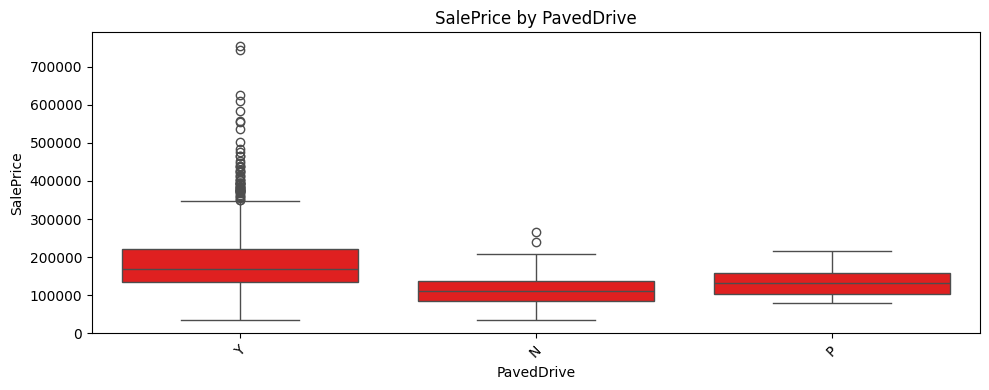

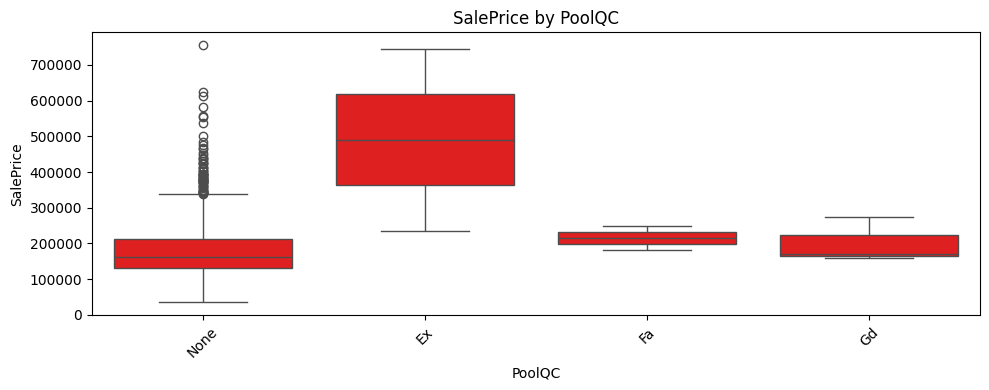

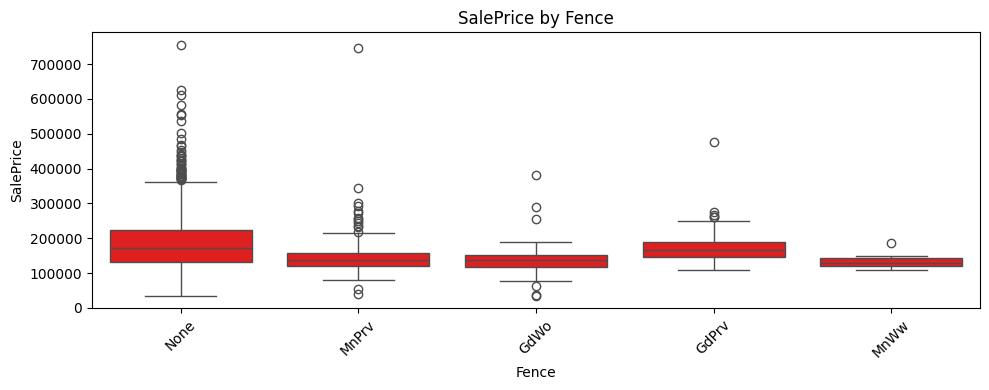

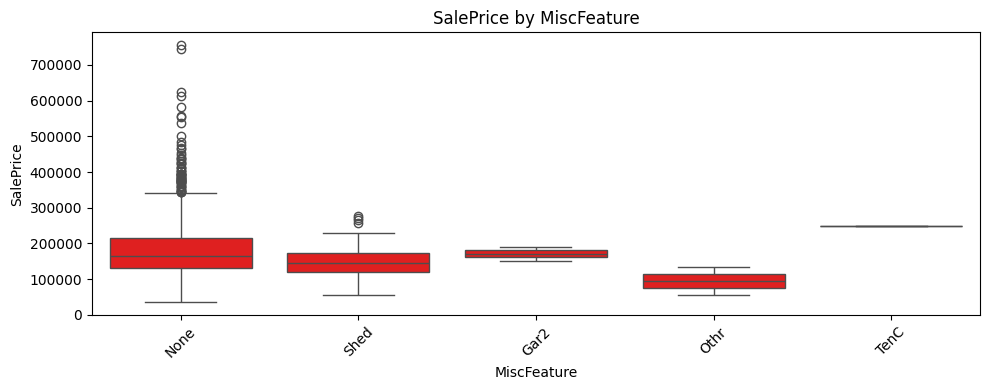

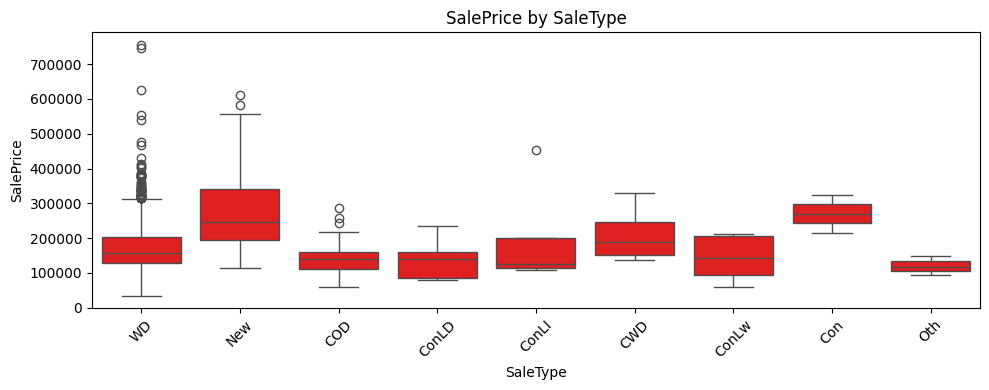

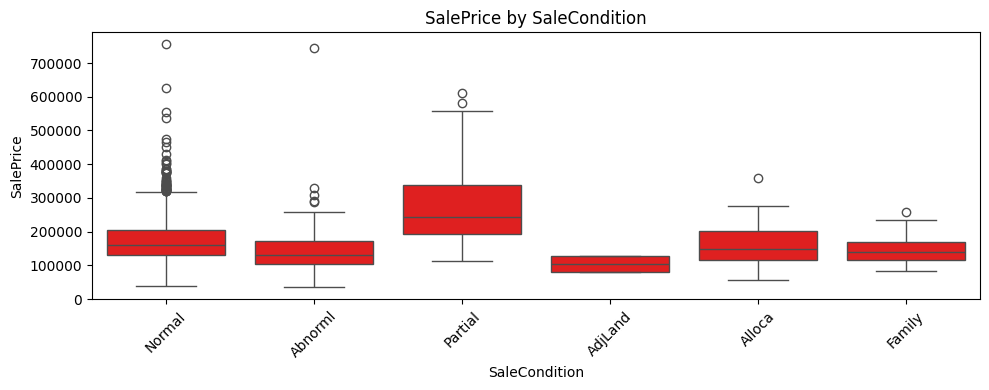

In [ ]:
# Value counts for each category
for col in categorical_cols:
    print(f"--- {col} ---")
    print(train_df[col].value_counts(dropna=False))
    print()

# Bar plots for each categorical variable vs. SalePrice
for col in categorical_cols:
    if train_df[col].nunique() <= 20:  # limit to avoid overplotting
        plt.figure(figsize=(10, 4))
        sns.boxplot(data=train_df, x=col, y='SalePrice',color="red")
        plt.xticks(rotation=45)
        plt.title(f"SalePrice by {col}")
        plt.tight_layout()
        plt.show()

We observe noticeable variations in the median SalePrice across categories for many of the plotted features. This suggests that these categorical variables are likely informative for predicting house prices.

For example: SaleCondition, GarageType .....

These differences in distribution indicate that the corresponding features have a meaningful relationship with the target variable (SalePrice). Therefore, they can be valuable inputs in our regression model.

##Correlation Analysis

In [ ]:
individual_features_df = []
for i in range(0, len(df_num.columns) - 1):
    tmpDf = df_num[[df_num.columns[i], 'SalePrice']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)
all_correlations = {feature.columns[0]: feature.corr()['SalePrice'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

   KitchenAbvGr: -0.1392006921778576
       HalfBath: -0.08439171127179902
     MSSubClass: -0.08428413512659509
    OverallCond: -0.07785589404867797
         YrSold: -0.028922585168736813
   BsmtHalfBath: -0.02883456718548182
             Id: -0.021916719443430967
       PoolArea: -0.014091521506356765
   BsmtFullBath: 0.011439163340408606
         MoSold: 0.046432245223819446
      3SsnPorch: 0.06393243256889088
    OpenPorchSF: 0.08645298857147718
        MiscVal: 0.08896338917298921
     Fireplaces: 0.12166058421363891
      BsmtUnfSF: 0.16926100049514173
   BedroomAbvGr: 0.18093669310848806
     WoodDeckSF: 0.1937060123752066
     BsmtFinSF2: 0.19895609430836594
  EnclosedPorch: 0.24127883630117497
    ScreenPorch: 0.2554300795487841
        LotArea: 0.2638433538714051
   LowQualFinSF: 0.30007501655501323
    LotFrontage: 0.34987561032244174
     MasVnrArea: 0.43409021975689227
     BsmtFinSF1: 0.47169042652357296
    GarageYrBlt: 0.4863616774878596
   YearRemodAdd: 0.50710096711

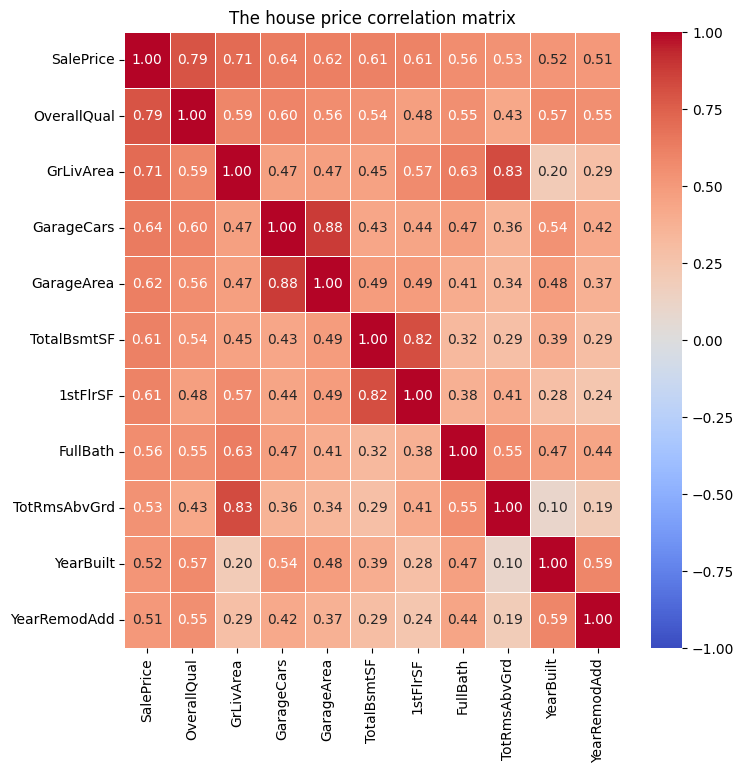

In [ ]:
#The 10 most correlated features with Sale Price
corr_matrix = df_num.corr()
top_10_features = corr_matrix['SalePrice'].abs().nlargest(11).index
top_10_corr_matrix = corr_matrix.loc[top_10_features, top_10_features]
plt.figure(figsize=(8, 8))
sns.heatmap(top_10_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('The house price correlation matrix')
plt.show()

The SalePrice target variable shows a high correlation with some of the features such as OverallQual (overall quality), GrLivArea (living area) and GarageCars (number of cars in the garage). This indicates that these characteristics strongly influence the value of the sale. It can also be noted that TotalBsmtSF (total basement area) and 1stFlrSF (ground floor area) also have a positive correlation with SalePrice, which confirms their importance for determining housing prices. However, some features, such as YearBuilt (year of construction), show a weaker correlation with the target variable, which may indicate that the age of the building has less impact on its value.

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

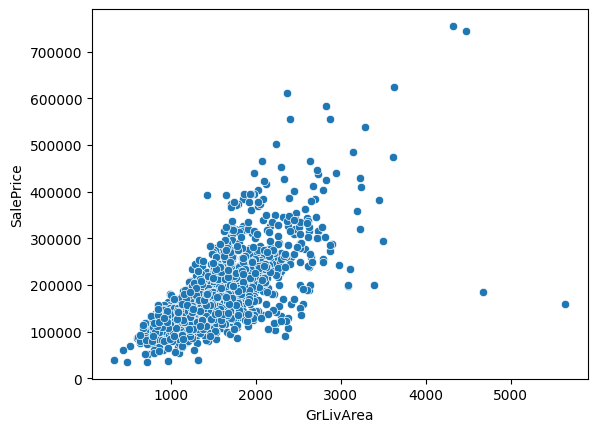

In [ ]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)

The scatter plot shows how the living area affects the selling price.  It demonstrates that the majority of homes have between 1,000 and 3,000 square feet of living space and a commensurate asking price.  The area of living space and the selling price are positively correlated; that is, when the area of living space grows, the sale price typically does as well.  But it's also possible to see that there is some point dispersion, which suggests that certain homes have a side, a small quantity of living space, and a greater price.  The fact that dispersion rises with area may suggest that cost is also influenced by other elements, such as location, equipment, and construction quality.

#Training models

##Test data loading and Preprocessing

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/competition/test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [ ]:
test_df[cols_fill_none] = test_df[cols_fill_none].fillna('None')

zero_fill_cols = ['MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea',
                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                  'BsmtFullBath', 'BsmtHalfBath']
test_df[zero_fill_cols] = test_df[zero_fill_cols].fillna(0)

mode_fill_cols = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
                  'Electrical', 'KitchenQual', 'Functional', 'SaleType']
for col in mode_fill_cols:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

In [ ]:
test_F=test_df.copy()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

#**Best submission**

In [ ]:
# 1. FEATURE ENGINEERING

def enhanced_feature_engineering(df):
    # Basic features
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    # Temporal features
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)

    # Quality features
    df['QualityScore'] = df['OverallQual'] * df['OverallCond']
    df['Qual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['Qual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    df['Qual_Baths'] = df['OverallQual'] * df['TotalBath']
    df['Qual_Age'] = df['OverallQual'] / (1 + df['Age'])

    # Boolean features
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasPorch'] = (df['TotalPorch'] > 0).astype(int)
    df['HasDeck'] = (df['WoodDeckSF'] > 0).astype(int)

    # Functional House Score (Total usable space * quality)
    df['TotalRms_Qual'] = df['TotRmsAbvGrd'] * df['OverallQual']
    df['GarageScore'] = df['GarageCars'] * df['GarageArea']
    df['Baths_per_Room'] = df['TotalBath'] / (df['TotRmsAbvGrd'] + 1)
    df['LivingArea_to_LotArea'] = df['GrLivArea'] / (df['LotArea'] + 1)

    # 7. Categorical Binning Ideas
    df['MSSubClass_str'] = df['MSSubClass'].astype(str)  # treat like a category

    # Optional: combine Porch/Deck types into one feature
    df['TotalOutdoorSpace'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    return df
def advanced_feature_engineering(df):
    df = enhanced_feature_engineering(df)

    # New temporal features
    df['YearsSinceRemodel'] = df['YrSold'] - df['YearRemodAdd']
    df['IsNewHouse'] = (df['YearBuilt'] == df['YrSold']).astype(int)

    # Quality interactions
    df['Qual_LotArea'] = df['OverallQual'] * df['LotArea']
    df['Qual_Kitchen'] = df['OverallQual'] * df['KitchenQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    # Garage features
    df['GarageScore'] = df['GarageCars'] * df['GarageArea']
    df['GarageTypeScore'] = df['GarageType'].map({
        'NA':0, 'Detchd':1, 'CarPort':1, 'BuiltIn':2, 'Basment':2, 'Attchd':2, '2Types':3
    }) * df['GarageArea']

    # Basement features
    df['BsmtScore'] = df['BsmtQual'].map({
        'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5
    }) * df['TotalBsmtSF']

    # Neighborhood premium
    premium_neighborhoods = ['StoneBr', 'NridgHt', 'NoRidge']
    df['PremiumLocation'] = df['Neighborhood'].isin(premium_neighborhoods).astype(int)

    # Seasonality
    df['SummerSale'] = df['MoSold'].isin([6,7,8]).astype(int)

    # Categorical interactions
    df['MSZoning_Quality'] = df['MSZoning'].map({
        'A':1, 'C':2, 'FV':4, 'I':1, 'RH':3, 'RL':4, 'RP':3, 'RM':3
    }) * df['OverallQual']

    return df
# Apply feature engineering
train_df = advanced_feature_engineering(train_df)
test_df = advanced_feature_engineering(test_df)


# 2. DATA PREPARATION

X = train_df.drop(['SalePrice', 'Id'], axis=1)
y = train_df['SalePrice']

# Try both log and Box-Cox transformations to see which works bette
use_boxcox = False  # Set to True to try Box-Cox instead of log

if use_boxcox:
    y_transformed, lambda_value = stats.boxcox(y + 1)  # +1 to handle zeros
    y = pd.Series(y_transformed)
else:
    y = np.log1p(y)  # Log transformation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
#normal encoding
cat_cols = X_train.select_dtypes(include=['object']).columns
# MEstimateEncoder for categorical variables
encoder = MEstimateEncoder(cols=cat_cols, m=5.0)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)
X_test = test_df.drop('Id', axis=1)
X_test_encoded = encoder.transform(X_test)

In [ ]:
"""
print("\nOptimizing CatBoost...")
cat_params = {
    'iterations': [2500,3000,3500],
    'learning_rate': [0.05,0.01,0.1,1],
    'depth': [3,4,5],
    'l2_leaf_reg': [0,1,2],
    #'subsample': [0.6],
    'colsample_bylevel': [0.5,0.7,0.8],
    'border_count': [30,50,60],
    'bootstrap_type': ['Bayesian','MVS'],
    'bagging_temperature': [1]
}
"""
# Define the model with best parameters(after many gridSearches)
catboost_model = CatBoostRegressor(
    learning_rate=0.01,
    l2_leaf_reg=0,
    iterations=3500,
    depth=4,
    colsample_bylevel=0.7,
    border_count=50,
    bootstrap_type='Bayesian',
    bagging_temperature=1,
    random_seed=42
)
# Fit the model directly
catboost_model.fit(X_train_encoded, y_train, eval_set=(X_val_encoded, y_val))

# Predict on validation
val_preds = catboost_model.predict(X_val_encoded)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"\n📊 CatBoost RMSE on validation set: {val_rmse:.5f}")

# Predict on test
test_preds = catboost_model.predict(X_test_encoded)

# Inverse transform (log or Box-Cox)
if use_boxcox:
    final_pred = stats.inv_boxcox(test_preds, lambda_value) - 1
else:
    final_pred = np.expm1(test_preds)

# Optional clipping for stability
q1, q99 = np.percentile(final_pred, [1, 99])
final_pred = np.clip(final_pred, q1, q99)

# Submission
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': final_pred
})
submission.to_csv('catboost_bestparam.csv', index=False)


print("📄 Submission saved: catboost_bestparam.csv")


0:	learn: 0.3877111	test: 0.4303928	best: 0.4303928 (0)	total: 8.07ms	remaining: 28.2s
1:	learn: 0.3851346	test: 0.4276913	best: 0.4276913 (1)	total: 27.8ms	remaining: 48.6s
2:	learn: 0.3826475	test: 0.4250197	best: 0.4250197 (2)	total: 50.1ms	remaining: 58.4s
3:	learn: 0.3802788	test: 0.4225113	best: 0.4225113 (3)	total: 68.4ms	remaining: 59.8s
4:	learn: 0.3779005	test: 0.4200542	best: 0.4200542 (4)	total: 93.3ms	remaining: 1m 5s
5:	learn: 0.3755650	test: 0.4176722	best: 0.4176722 (5)	total: 116ms	remaining: 1m 7s
6:	learn: 0.3730911	test: 0.4150877	best: 0.4150877 (6)	total: 135ms	remaining: 1m 7s
7:	learn: 0.3708011	test: 0.4126591	best: 0.4126591 (7)	total: 151ms	remaining: 1m 5s
8:	learn: 0.3683841	test: 0.4102615	best: 0.4102615 (8)	total: 163ms	remaining: 1m 3s
9:	learn: 0.3660317	test: 0.4077490	best: 0.4077490 (9)	total: 178ms	remaining: 1m 2s
10:	learn: 0.3636531	test: 0.4053715	best: 0.4053715 (10)	total: 200ms	remaining: 1m 3s
11:	learn: 0.3615119	test: 0.4032171	best: 0.40